In [1]:
from numpy import array,outer,exp,sqrt,pi,concatenate,log,roots,linspace,loadtxt
from scipy.sparse import coo_array
from matplotlib import pyplot as plt
R=8.31446261815324 # J/mol/K
k_B=1.380649e-23 # J/K
N_A=6.02214076e+23 # 1/mol
R=k_B*N_A


components_list=['H2','CH4','CO2','CO','H2O','N2','O2','Ar','He','C6H6','C6H12','C6H14'] # order of components
sigma_lj=array([2.827,3.758,3.941,3.69,2.641,3.798,3.467,3.542,2.551,5.349,6.182,5.949]) # Lennard Jones sigma, Angström 
epsilon_lj_ov_k=array([59.7,148.6,195.2,91.7,809.1,71.4,106.7,93.3,10.22,412.3,297.1,399.3]) # Lennard Jones epsilon/Boltztmann k, K
M=array([0.00201588,0.01604246,0.0440095,0.0280101,0.01801528,0.0280134,0.031998,0.039948,0.0040026,0.078114,0.084162,0.086178]) # kg/mol
# coefficients of NASA polynomials from Burcat, A., & Ruscic, B. (2001). Third millennium ideal gas and condensed phase thermochemical database for combustion. Technion-Israel Institute of Technology.
a1_a7_low=array([x.split('\t') for x in """2,34433112	0,007980521	-1,95E-05	2,02E-08	-7,38E-12	-917,935173	0,683010238
5,14825732	-0,013700241	4,94E-05	-4,92E-08	1,70E-11	-10245,3222	-4,63322726
2,356813	0,00898413	-7,12E-06	2,46E-09	-1,43E-13	-48371,971	9,9009035
3,5795335	-0,000610354	1,02E-06	9,07E-10	-9,04E-13	-14344,086	3,5084093
4,1986352	-0,002036402	6,52E-06	-5,49E-09	1,77E-12	-30293,726	-0,84900901
3,53100528	-0,000123661	-5,03E-07	2,44E-09	-1,41E-12	-1046,97628	2,96747038
3,78245636	-0,002996734	9,85E-06	-9,68E-09	3,24E-12	-1063,94356	3,65767573
2,5	0	0,00E+00	0,00E+00	0,00E+00	-745,375	4,37967491
2,5	0	0,00E+00	0,00E+00	0,00E+00	-745,375	0,928723974
0,504818632	0,018502064	7,38E-05	-1,18E-07	5,07E-11	8552,47913	21,6412893
4,04357527	-0,006196083	1,77E-04	-2,23E-07	8,64E-11	-16920,3544	8,52527441
9,87121167	-0,00936699	1,70E-04	-2,15E-07	8,45E-11	-23718,5495	-12,4999353
""".replace(',','.').split('\n') if len(x)>0],dtype=float) 
a1_a7_high=array([x.split('\t') for x in """2,93286575	0,000826608	-1,46E-07	1,54E-11	-6,89E-16	-813,065581	-1,02432865
1,911786	0,00960268	-3,38E-06	5,39E-10	-3,19E-14	-10099,2136	8,48241861
4,6365111	0,002741457	-9,96E-07	1,60E-10	-9,16E-15	-49024,904	-1,9348955
3,0484859	0,001351728	-4,86E-07	7,89E-11	-4,70E-15	-14266,117	6,0170977
2,6770389	0,002973182	-7,74E-07	9,44E-11	-4,27E-15	-29885,894	6,88255
2,95257637	0,0013969	-4,93E-07	7,86E-11	-4,61E-15	-923,948688	5,87188762
3,66096065	0,000656366	-1,41E-07	2,06E-11	-1,30E-15	-1215,97718	3,41536279
2,5	0	0,00E+00	0,00E+00	0,00E+00	-745,375	4,37967491
2,5	0	0,00E+00	0,00E+00	0,00E+00	-745,375	0,928723974
11,0809576	0,020717675	-7,52E-06	1,22E-09	-7,36E-14	4306,41035	-40,041331
13,214597	0,035824343	-1,32E-05	2,17E-09	-1,32E-13	-22809,2102	-55,3518322
19,5158086	0,026775394	-7,50E-06	1,20E-09	-7,52E-14	-29436,2466	-77,4895497
""".replace(',','.').split('\n') if len(x)>0],dtype=float)


Cp_R_coefs_200_1000_K=a1_a7_low[:,:4+1] # for Cp function, coefficients from a1 to a5 are applicable
Cp_R_coefs_1000_6000_K=a1_a7_high[:,:4+1] # for Cp function, coefficients from a1 to a5 are applicable
h_ig_coefs_200_1000_K=array([[1/1,1/2,1/3,1/4,1/5,1] for _ in range(a1_a7_low.shape[0])])*a1_a7_low[:,:6]
h_ig_coefs_1000_6000_K=array([[1/1,1/2,1/3,1/4,1/5,1] for _ in range(a1_a7_low.shape[0])])*a1_a7_high[:,:6]
s_ig_coefs_200_1000_K=array([[1,1,1/2,1/3,1/4,0,1] for _ in range(a1_a7_low.shape[0])])*a1_a7_low[:,:7]
s_ig_coefs_1000_6000_K=array([[1,1,1/2,1/3,1/4,0,1] for _ in range(a1_a7_low.shape[0])])*a1_a7_high[:,:7]


def mu(T):
    T_=outer(T,1/epsilon_lj_ov_k)
    MT=outer(T,M*1000)
    omega_mu=1.16145*T_**(-0.14874)+0.52487*exp(-0.77320*T_)+2.16178*exp(-2.43787*T_)
    return 5/16*sqrt(k_B/(pi*1000*N_A))*1/1e-10**2*sqrt(MT)/(sigma_lj**2*omega_mu)  # Pa s


def D_ij(T,p):
    """Returns binary diffusion coefficients for p in Pa, T in K."""
    eps_lj_ov_k_ij=sqrt(outer(epsilon_lj_ov_k,epsilon_lj_ov_k))
    sigma_lj_ij=1/2*(sigma_lj.reshape([len(sigma_lj),1])+sigma_lj.reshape([1,len(sigma_lj)]))
    M_ij=1/(1/2*(1/M.reshape([1,len(M)])+1/M.reshape([len(M),1])))
    Tstar=T/eps_lj_ov_k_ij
    omega_D=1.06036*Tstar**(-0.15610)+0.19300*exp(-0.47635*Tstar)+1.03587*exp(-1.52996*Tstar)+1.76474*exp(-3.89411*Tstar)
    c1=3/(16)*sqrt(4/pi)*(1.3806e-23)**(3/2)*(6.0221e23)**(1/2)*1000**(1/2)*100**2/(1e5*1e-10**2) # 0.0026633 cm^2/s
    return c1*T**(3/2)/((p/1e5)*M_ij**(1/2)*sigma_lj_ij**2*omega_D)*100**(-2)  # m^2/s


def cp_ig(T):
    result=((200<=T)&(T<=1000))*R*Cp_R_coefs_200_1000_K.dot(pow(T,array([[0],[1],[2],[3],[4]],dtype=float)))+\
            ((1000<T)&(T<=6000))*R*Cp_R_coefs_1000_6000_K.dot(pow(T,array([[0],[1],[2],[3],[4]],dtype=float)))
    return result.T # ensure row dimension is T


def h_ig(T):
    result=((200<=T)&(T<=1000))*R*T*h_ig_coefs_200_1000_K.dot(pow(T,array([[0],[1],[2],[3],[4],[-1]],dtype=float)))+\
            ((1000<T)&(T<=6000))*R*T*h_ig_coefs_1000_6000_K.dot(pow(T,array([[0],[1],[2],[3],[4],[-1]],dtype=float)))
    return result.T # ensure row dimension is T


def s_ig(T):
    result=((200<=T)&(T<=1000))*R*s_ig_coefs_200_1000_K.dot(concatenate([log(array(T,ndmin=2)),pow(T,array([[1],[2],[3],[4],[0],[0]],dtype=float))]))+\
            ((1000<T)&(T<=6000))*R*s_ig_coefs_1000_6000_K.dot(concatenate([log(array(T,ndmin=2)),pow(T,array([[1],[2],[3],[4],[0],[0]],dtype=float))]))
    return result.T # ensure row dimension is T


def cp_mid(T0,T):
    result=(
        ((200<=T)&(T<=1000))*R*h_ig_coefs_200_1000_K+((1000<T)&(T<=6000))*R*T*h_ig_coefs_1000_6000_K).dot(
            array([sum([(T**(i-j)*T0**j) for j in range(i,0-1,-1)]) for i in range(4+1)]))
    return result # ensure row dimension is T


def transp(T,x,p=101325):
    # mixture properties according to Bird R. B., Stweart W. E., Lightfoot E. N. (2002). Transport phenomena. 2nd ed. John Wiley & Sons. New York. S. 26, 276, 864
    T=array(T,ndmin=1)
    x=array(x,ndmin=2)
    viscosity=mu(T)
    heat_capacity=cp_ig(T)
    conductivity=(heat_capacity+5/4*R)*viscosity/M
    if T.shape[0]<=1:
        phi=(1/sqrt(8)*(1+outer(M,1/M))**(-1/2)*(1+outer(viscosity,1/viscosity)**(1/2)*outer(1/M,M)**(1/4))**2).T
        viscosity_mix=((x*viscosity)/x.dot(phi)).sum(axis=1) # semiempirical mixing rule
        conductivity_mix=((x*conductivity)/x.dot(phi)).sum(axis=1) # semiempirical mixing rule
    else:
        phi=array([[1/sqrt(8)*(1+M[i]/M[j])**(-1/2)*(1+(viscosity[:,i]/viscosity[:,j])**(1/2)*(M[j]/M[i])**(1/4))**2 for i in range(M.shape[0])] for j in range(M.shape[0])]).T
        phi=phi.reshape([phi.shape[0]*phi.shape[1],phi.shape[2]])
        cols=array(range(x.shape[0]*x.shape[1]))
        rows=array(x.shape[1]*[[j for j in range(x.shape[0])]]).T.ravel()
        x_t=coo_array((x.ravel(),(rows,cols)),shape=[len(T),len(T)*len(M)],dtype=float)
        viscosity_mix=((x*viscosity)/x_t.dot(phi)).sum(axis=1) # semiempirical mixing rule
        conductivity_mix=((x*conductivity)/x_t.dot(phi)).sum(axis=1) # semiempirical mixing rule
    heat_capacity_mix=(heat_capacity*x).sum(axis=1)
    density_mix=(p/R/T*(M*x).sum(axis=1))
    mol_mass_mix=(M*x).sum(axis=1)
    Pr=viscosity_mix*(heat_capacity_mix/mol_mass_mix)/conductivity_mix
    return viscosity_mix, conductivity_mix, heat_capacity_mix, density_mix, mol_mass_mix, Pr


T=1000. # K
viscosity=mu(T).flatten()
density=101325/8.3145/T*M
heat_capacity=cp_ig(T).flatten()
conductivity=(heat_capacity+5/4*R)*viscosity/M


x=array([0,0,0,0,0,0.79,0.21,0,0,0,0,0])
viscosity_air,conductivity_air,heat_capacity_air,density_air,mol_mass_air,Pr=transp(T,x)


x=array([0.4,0,0,0,0.6,0,0,0,0,0,0,0])
viscosity_1,conductivity_1,heat_capacity_1,density_1,mol_mass_1,Pr=transp(T,x)


x_mass=array([0.2,0.5,0.05,0.05,0.2,0,0,0,0,0,0,0]) # ref. CH4 with mass fractions {0.2, 0.5, 0.05, 0.05, 0.2, 0.0} for {"Hydrogen", "Methane", "Carbondioxide", "Carbonmonoxide", "Water", "Nitrogen"}
x_2=x_mass/M/sum(x_mass/M)
viscosity_2,conductivity_2,heat_capacity_2,density_2,mol_mass_2,Pr=transp(T,x_2)


print(f'viscosity, density, heat capacity, conductivity at {T}K')
print('\t\tviscosity/(Pa s)\tdensity/(kg/m^3)\tCp heat cap./(J/mol/K)\tconductivity/(W/m/K)\tmol mass/(kg/mol)')
for i in range(len(M)):
    print('{:s}\t\t{:0.16g}\t{:0.16g}\t{:16.16g}\t{:16.16g}\t{:16.16g}'.format(components_list[i],viscosity[i],density[i],heat_capacity[i],conductivity[i],M[i]))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:16.16g}'.format('N2:O2 79:21',viscosity_air.item(),density_air.item(),heat_capacity_air.item(),conductivity_air.item(),mol_mass_air.item()))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:16.16g}'.format('H2O:H2 60:40',viscosity_1.item(),density_1.item(),heat_capacity_1.item(),conductivity_1.item(),mol_mass_1.item()))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:16.16g}'.format('H2:..:H2O '+':'.join(['{:d}'.format(int(round(x*100,0))) for x in x if round(x*100,0)!=0]),viscosity_2.item(),density_2.item(),heat_capacity_2.item(),conductivity_2.item(),mol_mass_2.item()))


print('\n')
print('Example 23 from ref. [4] Stephan, P. u. a. (2013). VDI-Wärmeatlas. 11. bearb. und erw. Aufl. Berlin, Heidelberg: Springer-Verlag. S. 652.')
print('Benzene:Argon 25:75 mol, 100.6 °C, 1 bar')
T=273.15+100.6 # K
p=1e5 # Pa



x_3=array([0,0,0,0,0,0,0,0.75,0,0.25,0,0]) # ref. CH4 with mass fractions {0.2, 0.5, 0.05, 0.05, 0.2, 0.0} for {"Hydrogen", "Methane", "Carbondioxide", "Carbonmonoxide", "Water", "Nitrogen"}
viscosity_3,conductivity_3,heat_capacity_3,density_3,mol_mass_3,Pr=transp(T,x_3)


conductivity_3_2=(heat_capacity_3+5/4*R)*viscosity_3/sum(x_3*M)
print('\t\tviscosity/(Pa s)\tdensity/(kg/m^3)\tCp heat cap./(J/mol/K)\tconductivity/(W/m/K)')
for i in range(len(M)):
    print('{:s}\t\t{:0.16g}\t{:0.16g}\t{:16.16g}\t{:16.16g}'.format(components_list[i],viscosity[i],density[i],heat_capacity[i],conductivity[i]))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}'.format('N2:O2 79:21',viscosity_air.item(),density_air.item(),heat_capacity_air.item(),conductivity_air.item()))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}'.format('H2O:H2 95:5',viscosity_1.item(),density_1.item(),heat_capacity_1.item(),conductivity_1.item()))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}'.format(':'.join([components_list[i] for i in range(len(components_list)) if x_2[i]!=0])+' '+':'.join(['{:d}'.format(int(round(x_2[i]*100,0))) for i in range(len(components_list)) if round(x_2[i]*100,0)!=0]),viscosity_2.item(),density_2.item(),heat_capacity_2.item(),conductivity_2.item()))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g}'.format(':'.join([components_list[i] for i in range(len(components_list)) if   x_3[i]!=0])+' '+':'.join(['{:d}'.format(int(round(  x_3[i]*100,0))) for i in range(len(components_list)) if round(  x_3[i]*100,0)!=0]),viscosity_3.item(),density_3.item(),heat_capacity_3.item(),conductivity_3.item()))
print('{:s}\t{:0.16g}\t{:0.16g}\t{:0.16g}\t{:0.16g} {:s}'.format(':'.join([components_list[i] for i in range(len(components_list)) if   x_3[i]!=0])+' '+':'.join(['{:d}'.format(int(round(  x_3[i]*100,0))) for i in range(len(components_list)) if round(  x_3[i]*100,0)!=0]),viscosity_3.item(),density_3.item(),heat_capacity_3.item(),conductivity_3_2.item(),'<<-- as (Cp+(5/4)R)mu/M'))


print('')
x=array([[0,1,0,0,0,0,0,0,0,0,0,0],[0,0,0,0,0,0.79,0.21,0,0,0,0,0],[0,0,0,0,0,0.79,0.21,0,0,0,0,0],[0,0,0,0,0,0.79,0.21,0,0,0,0,0],[0,0,0.046,0,0.044,0.75,0.16,0,0,0,0,0]])
T=array([25,25,25,45,250])+273.15
p=array([5,1,1,1,1]).T*1e5
viscosity_mix,conductivity_mix,heat_capacity_mix,density_mix,mol_mass_mix,Pr=transp(T,x,p)
print('{:30s}{:8s}{:8s}{:20s}{:20s}{:20s}{:20s}'.format('comp.','T/°C','p/bar','viscosity/(Pa s)','density/(kg/m^3)','Cp heat cap./(J/mol/K)','conductivity/(W/m/K)'))
for i in range(x.shape[0]):
    print('{:30s}{:<8.5g}{:<8.5g}{:20.14}{:20.14}{:20.14}{:20.14}'.format(':'.join([components_list[j]+'({:d})'.format(int(round(x*100,0))) for j,x in enumerate(x[i,:]) if round(x*100,0)!=0]),T[i]-273.15,p[i]/1e5,viscosity_mix[i],density_mix[i],heat_capacity_mix[i],conductivity_mix[i]))



viscosity, density, heat capacity, conductivity at 1000.0K
		viscosity/(Pa s)	density/(kg/m^3)	Cp heat cap./(J/mol/K)	conductivity/(W/m/K)	mol mass/(kg/mol)
H2		1.963732591424931e-05	0.02456660544831318	30.30498670043658	0.3964527481579316	      0.00201588
CH4		2.728260649811419e-05	0.1955021058993325	71.90360841381917	0.1399578443060892	      0.01604246
CO2		3.915541553246456e-05	0.5363236018401587	54.35948267311666	0.05761059386324219	       0.0440095
CO		4.030153169688179e-05	0.3413462484214324	33.19282721770769	0.06271233418154948	       0.0280101
H2O		3.583647691306399e-05	0.2195439588670395	41.25830244395893	0.1027463082772026	      0.01801528
N2		3.949198080201114e-05	0.3413864640086595	32.71195844300502	0.06076746422948569	       0.0280134
O2		4.769251770839719e-05	0.3899449576041854	34.8851767183697	0.06748652971956097	        0.031998
Ar		5.210035408275034e-05	0.4868279631968247	20.7861565453831	0.04066409267174595	        0.039948
He		4.418401821122453e-05	0.0487778513440375



Test deltaH_LV= 2273.8834973926896 J/kg (99.6 °C)


Test Wagner+Rackett: hl= -280596.06977640267 J/mol (99.6 °C)


Test Wagner+zlv: hl= -280232.9930953256 J/mol (99.6 °C)


/tmp/ipykernel_2507514/635587080.py:105: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


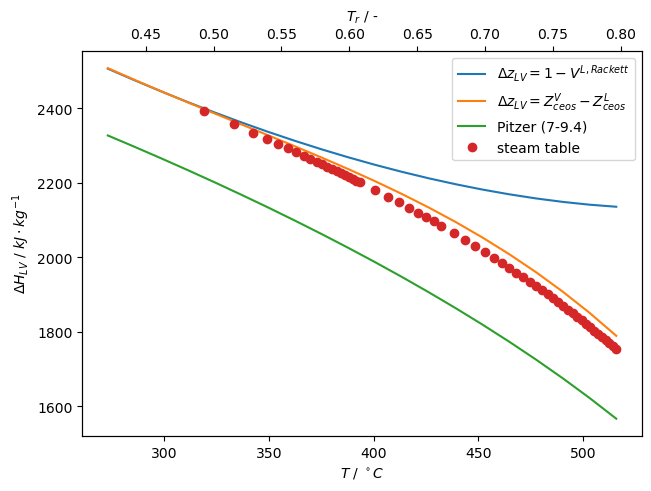

In [2]:
#Properties of gases and liquids p. 145 (eq. 4-11.2), 243 (Table 7-4), 777. (Section D)
#No. Formula Name CAS # Eq. #   A/A/Tc B/B/a C/C/b Tc/c to/d n/Pc E F      Pvpmin,bar  Tmin,K Pvpmax,bar   Tmax,K
#440 H2O water 7732-18-5    1   5.11564 1687.537 230.17                     0.01        273.20 16           473.20
#                           3   647.300 -7.77224 1.45684 -2.71942* -1.41336* 0.01 273.20 221 647.30
# Eq. # 1 : log_10(Pvp)=A-B/(T+C-273.15) (Antoine)
# Eq. # 3 : ln(Pvp/Pc)=(Tc/T)*(a*tau+b*tau^1.5+c*tau^2.5+d*tau^5), tau=(1-t/tc) Note: for water only the last two terms are c*tau^3+d*tau^6 (Wagner)
#No. Formula Name CAS # Mol. Wt. Tfp,K Tb,K Tc,K Pc,bar Vc,cm3/mol Zc=PcVc/RTc Omega
#440 H2O water 7732-18-5 18.015 273.15 373.15 647.14 220.64 55.95 0.229 0.344
tc=647.30 # K
pc=220.64e5 # bar
omega=0.344 # - acentric f.
pg=lambda t: 10**(5.11564-1687.537/(t+230.17-273.15)) # Antoine, water, t in K, psat in bar
psi=lambda t: 2.303*1687.537/tc*(t/tc/(t/tc+(230.17-273.15)/tc))**2 # Mod. Clausius-Clapeyron - Antoine, t in K, psi=-dlnpvr/(1/Tr)

pg=lambda t: pc*exp(tc/t*(-7.77224*(1-t/tc)+1.45684*(1-t/tc)**1.5-2.71942*(1-t/tc)**3-1.41336*(1-t/tc)**6)) # Wagner, t in K, psat in bar
psi=lambda t: (-(-7.77224)+1.45684*(1-t/tc)**0.5*(0.5*(1-t/tc)-1.5)+(-2.71942)*(1-t/tc)**2*(2*(1-t/tc)-3)+(-1.41336)*(1-t/tc)**5*(5*(1-t/tc)-6)) # Mod. Clausius-Clapeyron - Wagner, t in K, psi=-dlnpvr/(1/Tr)
vs=lambda t: R*tc/pc*0.229**(1+(1-t/tc)**(2/7)) # Rackett, t in K, Vsat in m^3/mol

def z(p,t,tc,pc,w,zc=0,eq='PR',c1=0,c2=0,c3=0,N=0):
    if eq=='RKS':
        zc=0.3333 # z_mc
        apc_rtc2=0.42188 # Omega=aPc/(RTc)^2 -> psi
        bpcrtc=0.08333 # bPc/(RTc)
        dpcrtc=0.08333 # dPc/(RTc)
        e_pcrtc2=0.00736 # e*(Pc/(RTc))^2
        alpha=(1+(0.4998+1.5928*w-0.19563*w**2+0.025*w**3)*(1-(t/tc)**(1/2)))**2

    elif eq=='PT':
        zc=0.2695 # z_mc
        omega_b_roots=roots([1,(2-3*zc),3*zc**2,-zc**3])
        omega_b=min(omega_b_roots[omega_b_roots>=0])
        omega_a=3*zc**2+3*(1-2*zc)*omega_b+omega_b**2+1-3*zc
        omega_c=1-3*zc
        apc_rtc2=omega_a # Omega=aPc/(RTc)^2 -> psi
        bpcrtc=omega_b # bPc/(RTc)
        cpcrtc=omega_c # cPc/(RTc)
        dpcrtc=bpcrtc+cpcrtc # dPc/(RTc)
        e_pcrtc2=-bpcrtc*cpcrtc # e*(Pc/(RTc))^2
        alpha=1+c1*(t/tc-1)+c2*(sqrt(t/tc)-1)+c3*((t/tc)**N-1)

    else: #eq=='PR':
        zc=0.3070 # z_mc
        apc_rtc2=0.45724 # Omega=aPc/(RTc)^2 -> psi
        bpcrtc=0.0778 # bPc/(RTc)
        dpcrtc=0.15559 # dPc/(RTc)
        e_pcrtc2=-0.006053 # e*(Pc/(RTc))^2
        alpha=(1+(0.3746+1.54226*w-0.26992*w**2)*(1-(t/tc)**(1/2)))**2
        #alpha0=(t/tc)**-0.171813*exp(0.125283*(1-(t/tc)**1.77634))
        #alpha1=(t/tc)**-0.607352*exp(0.511614*(1-(t/tc)**2.20517))
        #alpha=alpha0+w*(alpha0-alpha1)
        
    bprime=bpcrtc*(p/pc)/(t/tc) # B'=bp/(RT)
    dprime=dpcrtc*(p/pc)/(t/tc) # d'=dp/(RT)
    tprime=apc_rtc2*(p/pc)/(t/tc)**2*alpha # theta*p/(RT)^2=(a*alpha)*p/(RT)^2=(aPc/(RTc^2))*(RTc)^2/*alphaPc*p/(RT)*alpha
    eprime=e_pcrtc2*(p/pc)**2/(t/tc)**2
    etaprime=bprime
    a3=1
    a2=dprime-bprime-1
    a1=tprime+eprime-dprime*(bprime+1)
    a0=-(eprime*(bprime+1)+tprime*etaprime)
    return roots([a3,a2,a1,a0]),bpcrtc*(p/pc)/(t/tc)

z_1,z_min=z(1e5,273.15+99.6,tc,pc,omega,eq='PT',c1=0.60462,c2=-2.56713)
z_1=z_1[z_1>=z_min]
delta_zlv=max(z_1)-min(z_1)
dh_lv=psi(273.15+99.6)*R*tc/0.018/1000*delta_zlv
print('\n\nTest deltaH_LV=',dh_lv,'J/kg (99.6 °C)')

hl=h_ig(273.15+99.6)[:,4]-psi(273.15+99.6)*R*tc*(1-vs(273.15+99.6)*1e5/(R*273.15+99.6))
print('\n\nTest Wagner+Rackett: hl=',hl.item(),'J/mol (99.6 °C)')

hl=h_ig(273.15+99.6)[:,4]-psi(273.15+99.6)*R*tc*delta_zlv
print('\n\nTest Wagner+zlv: hl=',hl.item(),'J/mol (99.6 °C)')

t=linspace(273.15,242.6+273.15,20)
p=pg(t)
h_ref=h_ig(t)[:,4]
dh_lv_r=psi(t)*R*tc*(1-vs(t)*1e5/(R*t))

delta_zlv=array([max(x[0][x[0]>=x[1]])-min(x[0][x[0]>=x[1]]) for x in [z(p[j],t[j],tc,pc,omega,eq='PT',c1=0.60462,c2=-2.56713) for j in range(t.shape[0])]])

dh_lv_z=psi(t)*R*tc*delta_zlv

dh_lv_p=(7.08*(1-t/tc)**0.354+10.95*0.229*(1-t/tc)**0.456)*R*tc # Pitzer (7-9.4)

t_t,dh_lv_t=loadtxt('steam_table.csv',usecols=[2,5],skiprows=2).T

def convert_ax(ax):
    x0,x1=ax.get_xlim()
    twiny0.set_xlim(x0/tc,x1/tc)
    twiny0.figure.canvas.draw()

fig,ax=plt.subplots(1,1,constrained_layout=True)
twiny0=ax.twiny()
#twiny0.spines.bottom.set_position(("axes", -0.75))
ax.callbacks.connect('ylim_changed',convert_ax)
ax.plot(t,dh_lv_r/0.018/1000,label=r'$\Delta z_{LV}=1-V^{L,Rackett}$')
ax.plot(t,dh_lv_z/0.018/1000,label=r'$\Delta z_{LV}=Z^V_{ceos}-Z^L_{ceos}$')
ax.plot(t,dh_lv_p/0.018/1000,label=r'Pitzer (7-9.4)')
ax.plot(t_t+273.15,dh_lv_t,'o',label='steam table')
ax.set_ylabel(r'$\Delta H_{LV}$ / $kJ\cdot kg^{-1}$')
ax.set_xlabel(r'$T$ / $^\circ C$')
twiny0.set_xlabel(r'$T_r$ / -')
ax.legend(loc='best')
fig.show()